<a href="https://colab.research.google.com/github/Praveen-98cs/Research/blob/main/LRCN_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pafy
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
seed_constant=27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [8]:
!mkdir dataset

In [10]:
!cd dataset

In [11]:
!mkdir fight

In [12]:
!mkdir nofight

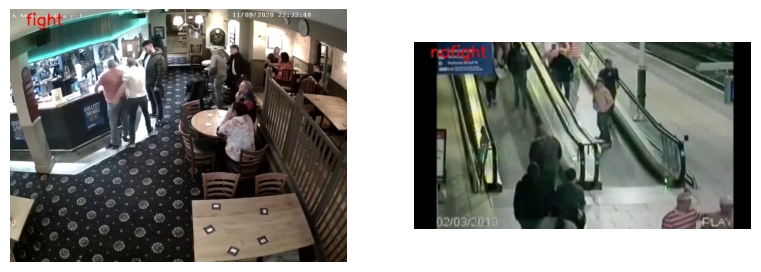

In [23]:
plt.figure(figsize=(20,20))
dataset_path = '/content/dataset'  # Path to the dataset folder inside Colab
_2classes=os.listdir(dataset_path)
random_range=random.sample(range(len(_2classes)),2)

for counter,i in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = _2classes[i]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(os.path.join(dataset_path, selected_class_Name))

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(os.path.join(dataset_path, selected_class_Name, selected_video_file_name))

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write  the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [24]:
IMAGE_HEIGHT,IMAGE_WIDTH=64,64#dimensions of the frame
SEQUENCE_LENGTH=20#no owf frames of a video which would be fed
DATASET_DIR= '/content/dataset'

In [29]:
CLASSES_LIST=["fight","nofight"]

In [30]:
def frames_extraction(video_path):
    frames_list=[]
    video_reader=cv2.VideoCapture(video_path)
    video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1)#the interval after which frrames get aadded
    #iterate thru frames
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames_window)
        success,frame=video_reader.read()
        if not success:
            break
        resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
        normalized_frame=resized_frame/255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [31]:
import os
frames2=0
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)


            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)
    frames2=frames

    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: fight


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:


features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state=seed_constant
                                                                            )

In [ ]:

def create_LRCN_model():



    model = Sequential()


    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'tanh'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'tanh')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'tanh')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'tanh')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

In [ ]:
LRCN_model = create_LRCN_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, 20, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_25 (TimeDis (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, 20, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_27 (TimeDis (None, 20, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 20, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_30 (TimeDis (None, 20, 4, 4, 64)     

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 12, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
45/45 [==============================] - 8s 119ms/step - loss: 0.7018 - accuracy: 0.4611 - val_loss: 0.6947 - val_accuracy: 0.4889
Epoch 2/70
45/45 [==============================] - 5s 101ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6898 - val_accuracy: 0.4667
Epoch 3/70
45/45 [==============================] - 5s 108ms/step - loss: 0.6957 - accuracy: 0.4722 - val_loss: 0.6890 - val_accuracy: 0.5333
Epoch 4/70
45/45 [==============================] - 5s 108ms/step - loss: 0.6970 - accuracy: 0.5278 - val_loss: 0.6920 - val_accuracy: 0.5111
Epoch 5/70
45/45 [==============================] - 5s 116ms/step - loss: 0.6889 - accuracy: 0.5000 - val_loss: 0.6906 - val_accuracy: 0.4889
Epoch 6/70
45/45 [==============================] - 5s 117ms/step - loss: 0.6889 - accuracy: 0.5111 - val_loss: 0.6671 - val_accuracy: 0.6444
Epoch 7/70
45/45 [==============================] - 5s 108ms/step - loss: 0.6784 - accuracy: 0.5333 - val_loss: 0.6846 - val_accuracy: 0.5333
Epoch 

In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)#without regularization patience=10


3/3 [==============================] - 1s 133ms/step - loss: 0.5880 - accuracy: 0.7333


In [ ]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)#without regularization patience=12

3/3 [==============================] - 1s 150ms/step - loss: 0.5820 - accuracy: 0.7200


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):


    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]


    epochs = range(len(metric_value_1))


    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))



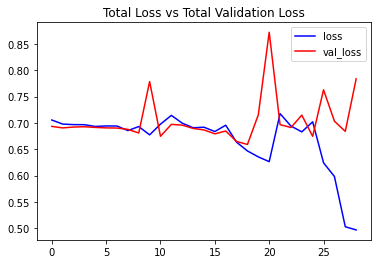

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')#wo regularization p=10

Vis

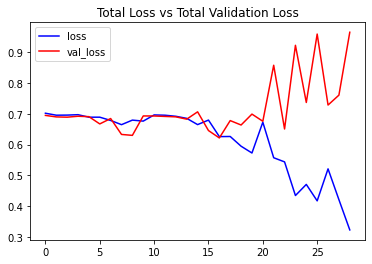

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')#paatience 12

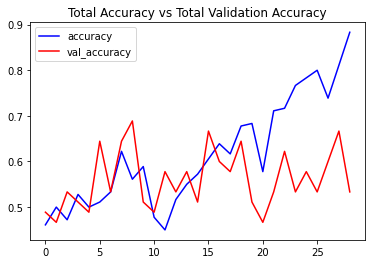

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

DEMO

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):


    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

In [ ]:
output_video_file_path = f'{test_videos_directory}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(r'C:\Users\ASUS\Downloads\g.mp4',output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


with reg

In [ ]:
from keras import regularizers
def create_LRCN_model():



    model = Sequential()


    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'tanh'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'tanh')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'tanh')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'tanh',kernel_regularizer=regularizers.l2(0.01))))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'sigmoid'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

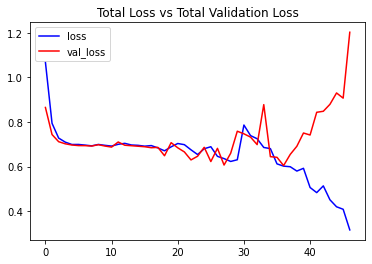

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')#with reg p=12